In [1]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import itertools
import random
from matplotlib import pyplot as plt
from data_generation import ExecutePairTrading, generate_training_data
random.seed(23)
import cProfile
import pstats
import pickle
import plotly.express as px
from time import time
import warnings
warnings.filterwarnings('ignore')

def chunker(seq, size):
    # split a list into chunks
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

/tmp/ipykernel_11498/2211131098.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
# data = pd.read_csv('../Data/sp500_full_20181231_to_20231229.csv')
data = pd.read_csv('../Data/sp500_full_19991201_to_20231231.csv')
value_count_tb = data[['Ticker']].groupby('Ticker').size().reset_index()
value_count_tb.columns = ['Ticker', 'Count']
stock_to_keep = value_count_tb['Ticker'][value_count_tb.Count==value_count_tb.Count.max()]
data = data[data.Ticker.isin(stock_to_keep)]

# Generate for all pairs

In [5]:
tickers = list(set(data.Ticker.values))
combinations = list(itertools.combinations(tickers, 2))
len(combinations)
batches = list(chunker(combinations, 1000))

In [6]:
len(data)

2169122

In [10]:
# This code allows you to reimport the module if changes happen in data_generation.py
from importlib import reload
import data_generation
reload(data_generation)
from data_generation import ExecutePairTrading, generate_training_data

i = 0
for batch in batches:
    start_ts=time()
    print(f'Getting {i+1}th out of {len(batches)} batches')
    max_pairs = 1
    features_tb, labels_tb = generate_training_data(
        data=data,
        moving_average=60,
        training_len=300,
        test_len=60,
        entry_signal=2,
        exit_signal=0.5,
        calculate_label=True,
        verbose=False,
        max_combinations=max_pairs,
        combinations=batch
    )
    combined = pd.merge(features_tb, labels_tb, how='left', on=['Date', 'Ticker_P1','Ticker_P2']).reset_index(drop=True)
    combined = combined[combined.pnls.notnull()].reset_index(drop=True)
    combined.to_csv(f'../Data/Training/pair_features_{i+1}_pairs{max_pairs}_300_120.csv', index=False)
    end_ts = time()
    print(f"Took {end_ts - start_ts} seconds")
    i+=1
    break
    
len(combined)
combined

Getting 1th out of 64 batches
1000 stock pairs detected
Took 0.5120048522949219 to initilize. Entering ticker pair loop
Max combination = 1
Took 12.284601926803589 to finish
Took 12.390101909637451 seconds


,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread,actual_abs_spread_std
0,ALB,2001-02-09 00:00:00,12.275000,12.050000,112600.0,8.619642,FDS,24.213333,23.299999,59100.0,18.648552,10.028910,10.204766,2.249121,10.912620,1.450967,0.000000,8.897203,1.242677
1,ALB,2001-02-12 00:00:00,12.260000,12.000000,80400.0,8.602054,FDS,24.626667,23.320000,181350.0,18.579535,9.977481,10.200591,2.248374,10.891524,1.455274,0.000000,8.936340,1.311173
2,ALB,2001-02-13 00:00:00,12.265000,12.100000,66400.0,8.528172,FDS,23.766666,22.333332,108450.0,17.862906,9.334734,10.194060,2.248033,10.859780,1.468273,0.000000,8.991768,1.394490
3,ALB,2001-02-14 00:00:00,12.175000,11.975000,221400.0,8.549283,FDS,23.266666,22.299999,64050.0,18.176107,9.626824,10.188217,2.247218,10.825338,1.472620,0.000000,9.042389,1.469722
4,ALB,2001-02-15 00:00:00,12.400000,12.160000,155400.0,8.616123,FDS,23.493334,23.100000,66000.0,18.579535,9.963411,10.182112,2.245326,10.786448,1.463886,0.000000,9.087282,1.536778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5693,ALB,2023-09-28 00:00:00,173.279999,163.520004,2547500.0,171.907639,FDS,445.000000,435.440002,327200.0,439.975281,268.067642,181.762312,34.812197,226.532454,29.760891,-0.050404,309.765209,20.330504
5694,ALB,2023-09-29 00:00:00,176.830002,169.690002,1969600.0,169.554382,FDS,446.660004,436.690002,275400.0,435.394928,265.840546,182.042292,35.149012,228.259514,28.961284,-0.046686,310.649819,19.539359
5695,ALB,2023-10-02 00:00:00,169.589996,161.369995,1949900.0,161.946182,FDS,440.929993,432.350006,235300.0,434.209991,272.263809,182.339956,35.532874,230.318735,27.568257,-0.058532,311.510140,18.958031
5696,ALB,2023-10-03 00:00:00,161.300003,155.149994,2514900.0,156.322281,FDS,438.619995,432.970001,363900.0,433.871460,277.549179,182.681280,35.952920,232.374705,26.368375,0.061074,312.323447,18.525447


count    5698.000000
mean        0.000264
std         0.046842
min        -0.217029
25%        -0.002175
50%         0.000000
75%         0.017905
max         0.208105
Name: pnls, dtype: float64

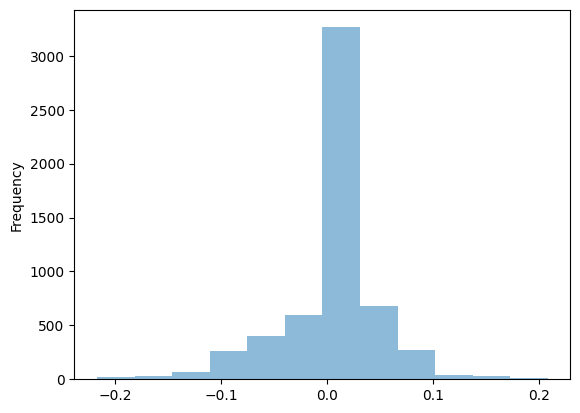

In [11]:
labels_tb
labels_tb = labels_tb.dropna()
labels_tb.pnls.plot.hist(bins=12, alpha=0.5)
labels_tb.pnls.describe()